# Sparse Modeling For Beginner 4
## Contents:
1. K-SVD for Random Matrix
2. K-SVD for Image
3. Denoising by K-SVD

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams["font.family"] = "IPAexGothic"

np.random.seed(41)


Bad key "backend in file /Users/masui/.matplotlib/matplotlibrc, line 1 ('"backend : Tkagg"')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.2/matplotlibrc.template
or from the matplotlib source distribution


# 1. K-SVD for Random Matrix

In [2]:
from spmimage.decomposition import KSVD

Y = np.random.rand(100,200)
ksvd = KSVD(n_components=50, transform_n_nonzero_coefs=5)
X = ksvd.fit_transform(Y)
D = ksvd.components_

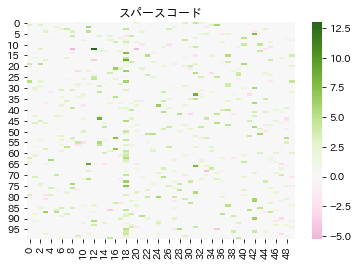

In [3]:
sns.heatmap(X, center = 0, cmap='PiYG')
plt.title("スパースコード")
plt.savefig("./img/sparse_code.png")

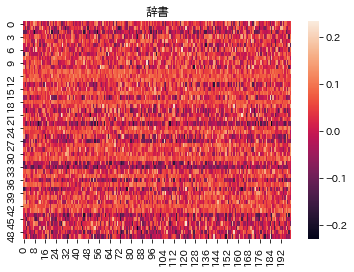

In [4]:
sns.heatmap(D)
plt.title("辞書")
plt.savefig("./img/dictionary.png")

Mean Absolute Error: 0.12821788379791454


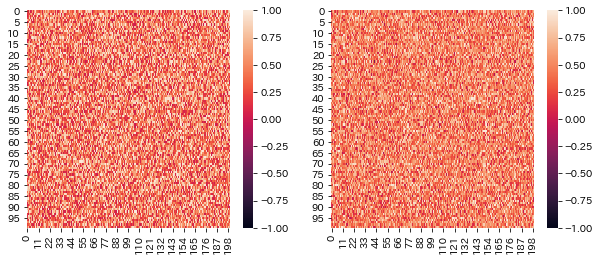

In [5]:
error = Y - X.dot(D)

vmin = -1.0
vmax = 1.0
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.heatmap(Y, vmin=vmin, vmax=vmax)
plt.subplot(1,2,2)
sns.heatmap(X.dot(D), vmin=vmin, vmax=vmax)

print("Mean Absolute Error:", np.mean(np.abs(error)))

# 2. K-SVD for Image

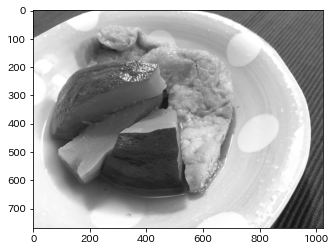

In [6]:
from PIL import Image
img = np.asarray(Image.open("img/recipe.jpg").convert('L'))
plt.imshow(img, cmap='gray')

In [7]:
patch_size = (8, 8)
n_components = 50
transform_n_nonzero_coefs = 5
max_iter = 10

In [8]:
from sklearn.preprocessing import StandardScaler
from spmimage.feature_extraction.image import extract_simple_patches_2d, reconstruct_from_simple_patches_2d
patches = extract_simple_patches_2d(img, patch_size)
print("shape:", patches.shape, "dtype:", patches.dtype)

patches = patches.reshape(-1, np.prod(patch_size)).astype(np.float64)
print("shape:", patches.shape, "dtype:", patches.dtype)

scl = StandardScaler()
Y = scl.fit_transform(patches)

shape: (12288, 8, 8) dtype: uint8
shape: (12288, 64) dtype: float64


In [9]:
%%time
ksvd = KSVD(n_components=n_components, transform_n_nonzero_coefs=transform_n_nonzero_coefs, max_iter=max_iter)
X = ksvd.fit_transform(Y)
D = ksvd.components_

CPU times: user 25.8 s, sys: 1.08 s, total: 26.8 s
Wall time: 21.8 s


In [10]:
reconstructed_patches = np.dot(X, D)
reconstructed_patches = scl.inverse_transform(reconstructed_patches)
reconstructed_patches = reconstructed_patches.reshape(-1, patch_size[0], patch_size[1])
reconstructed_img = reconstruct_from_simple_patches_2d(reconstructed_patches, img.shape)
reconstructed_img[reconstructed_img < 0] = 0
reconstructed_img[reconstructed_img > 255] = 255
reconstructed_img = reconstructed_img.astype(np.uint8)

PSNR: 34.779079760849726
SSIM: 0.9300166680104772


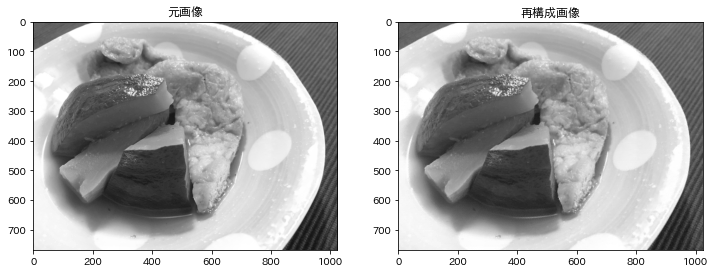

In [11]:
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title("元画像")
plt.subplot(1,2,2)
plt.imshow(reconstructed_img, cmap='gray')
plt.title("再構成画像")
plt.savefig("./img/reconstruct.png")

print("PSNR:", compare_psnr(img, reconstructed_img))
print("SSIM:", compare_ssim(img, reconstructed_img))

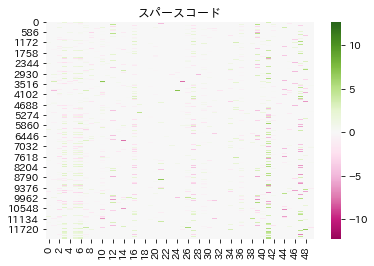

In [12]:
sns.heatmap(X, center = 0, cmap='PiYG')
plt.title("スパースコード")
plt.savefig("./img/image_sparse_code.png")

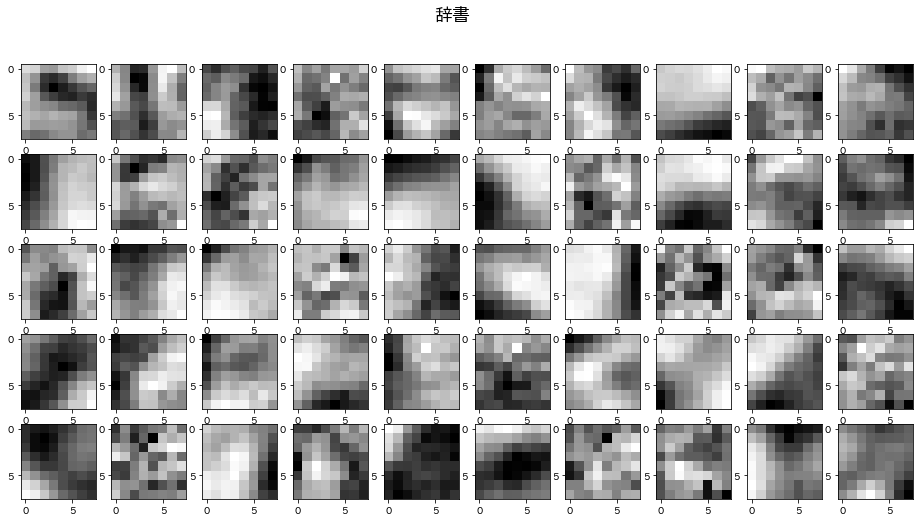

In [13]:
# 辞書をパッチサイズの画像に変形して表示
plt.figure(figsize=(16, 8))
for i, base in enumerate(D):
    plt.subplot(5, 10, i + 1)
    plt.imshow(base.reshape(patch_size), 'gray', interpolation='nearest')
plt.suptitle("辞書", fontsize=18)
plt.savefig("./img/image_dictionary.png")

# 3. Denoising by K-SVD

In [14]:
true_img = np.asarray(Image.open("img/recipe.jpg").convert('L'))
noise = (np.random.rand(*img.shape) - 0.5) * 20
img = true_img.copy().astype(np.float64) + noise

PSNR: 16.711167648885944
SSIM: 0.6850652089922017


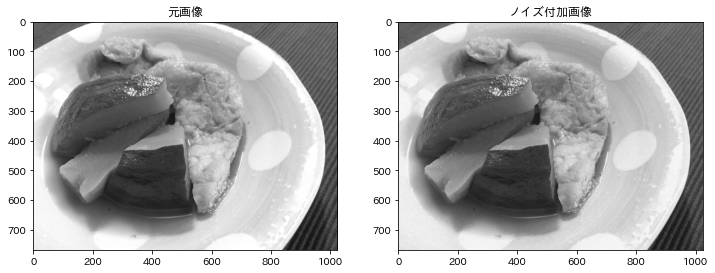

In [15]:
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(true_img, cmap='gray')
plt.title("元画像")
plt.subplot(1,2,2)
plt.imshow(img, cmap='gray')
plt.title("ノイズ付加画像")
print("PSNR:", compare_psnr(true_img, img.astype(np.uint8)))
print("SSIM:", compare_ssim(true_img, img.astype(np.uint8)))

In [16]:
patch_size = (8, 8)
n_components = 50
transform_n_nonzero_coefs = 5
max_iter = 10

In [17]:
from sklearn.preprocessing import StandardScaler
from spmimage.feature_extraction.image import extract_simple_patches_2d, reconstruct_from_simple_patches_2d
patches = extract_simple_patches_2d(img, patch_size)
print("shape:", patches.shape, "dtype:", patches.dtype)

patches = patches.reshape(-1, np.prod(patch_size)).astype(np.float64)
print("shape:", patches.shape, "dtype:", patches.dtype)

scl = StandardScaler()
Y = scl.fit_transform(patches)

shape: (12288, 8, 8) dtype: float64
shape: (12288, 64) dtype: float64


In [18]:
%%time
ksvd = KSVD(n_components=n_components, transform_n_nonzero_coefs=transform_n_nonzero_coefs, max_iter=max_iter)
X = ksvd.fit_transform(Y)
D = ksvd.components_

CPU times: user 26 s, sys: 1.08 s, total: 27 s
Wall time: 22.1 s


In [19]:
reconstructed_patches = np.dot(X, D)
reconstructed_patches = scl.inverse_transform(reconstructed_patches)
reconstructed_patches = reconstructed_patches.reshape(-1, patch_size[0], patch_size[1])
reconstructed_img = reconstruct_from_simple_patches_2d(reconstructed_patches, img.shape)
reconstructed_img[reconstructed_img < 0] = 0
reconstructed_img[reconstructed_img > 255] = 255
reconstructed_img = reconstructed_img.astype(np.uint8)

PSNR: 34.1461578176576
SSIM: 0.8929819590058261


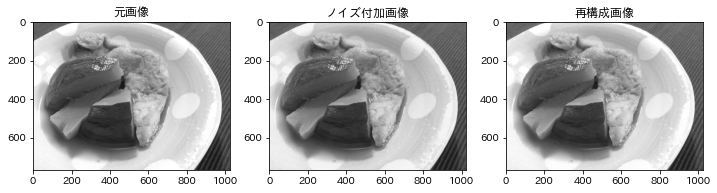

In [20]:
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(true_img, cmap='gray')
plt.title("元画像")
plt.subplot(1,3,2)
plt.imshow(img, cmap='gray')
plt.title("ノイズ付加画像")
plt.subplot(1,3,3)
plt.imshow(reconstructed_img, cmap='gray')
plt.title("再構成画像")
plt.savefig("./img/denoise.png")


print("PSNR:", compare_psnr(true_img, reconstructed_img))
print("SSIM:", compare_ssim(true_img, reconstructed_img))